In [24]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 4.9 MB/s 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image
import kornia
import torch
from scipy import spatial
import random
from skimage.transform import ProjectiveTransform, warp

In [2]:
# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [6]:
# 1. Preprocessing

img1 = plt.imread('parliament-left.jpg')
img2 = plt.imread('parliament-right.jpg')


H1, W1, C1= img1.shape
H2, W2, C1= img2.shape
_img2= np.zeros((H1,W1,C1), dtype=np.uint8)
_img2[:H2, :W2,] = img2.copy()
img2 = _img2
img1_gray = cv.cvtColor(img1,cv.COLOR_RGB2GRAY)
img2_gray = cv.cvtColor(img2,cv.COLOR_RGB2GRAY)

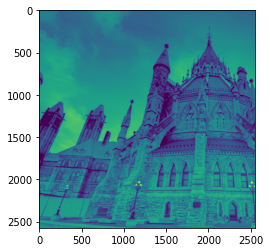

In [7]:
plt.imshow(img1_gray)

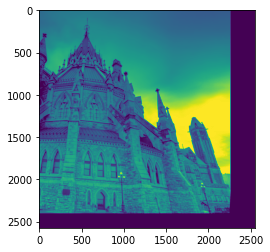

In [8]:
plt.imshow(img2_gray)

In [9]:
# 2. Detect keypoints and extract descriptors
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_gray,None)
img_1=cv.drawKeypoints(img1_gray,kp1,img1,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# sift = cv.SIFT_create()
kp2, des2 = sift.detectAndCompute(img2_gray,None)
img_2=cv.drawKeypoints(img2_gray,kp2,img2,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

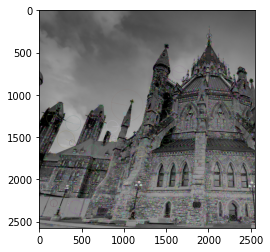

In [10]:
plt.imshow(img_1)

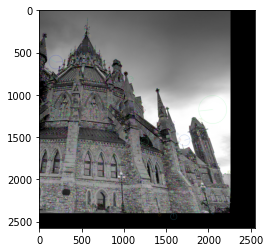

In [11]:
plt.imshow(img_2)

In [12]:
# 3.Match features
scores, matches = kornia.feature.match_snn(torch.from_numpy(des1),torch.from_numpy(des2),0.1)
matches_ = [x for _, x in sorted(zip(scores.numpy(), matches.numpy()))]

# 4. Prune features
res = []
m = matches_
scores = sorted(scores.numpy()[:200])
m = m[:200]
kp1, kp2 = np.array(kp1), np.array(kp2)
for item in m:
  x1, y1 = kp1[item[0]].pt
  x2, y2 = kp2[item[1]].pt
  res.append([x1, y1, x2, y2])
res = np.array(res, dtype = 'int')

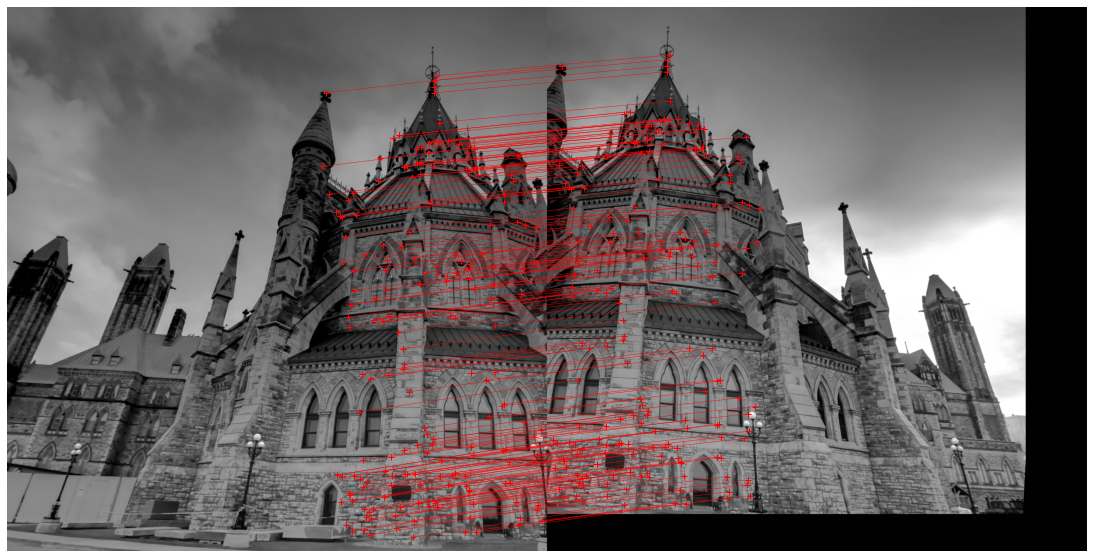

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1_gray, img2_gray, res)

In [14]:
def compute_homography(Matches):
    A = []
    for match in Matches:
        p1 = np.matrix([match[0], match[1], 1])
        p2 = np.matrix([match[2], match[3], 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        A.append(a1)
        A.append(a2)

    A = np.matrix(A)

    u, s, v = np.linalg.svd(A)
    h = np.reshape(v[8], (3, 3))
    h = (1/h.item(8)) * h
    return h

In [15]:
def ransac(res, threshold = 0.9, iteration = 1000):
    max_linear = []
    length = len(res)
    for i in range(iteration):
        m1 = res[random.randrange(0, length)]
        m2 = res[random.randrange(0, length)]
        m3 = res[random.randrange(0, length)]
        m4 = res[random.randrange(0, length)]
        Matches = np.vstack((m1, m2))
        Matches = np.vstack((Matches, m3))
        Matches = np.vstack((Matches, m4))
        h = compute_homography(Matches)
        inliers = []
        all_error= 0
        for i in range(length):
            p1 = np.transpose(np.matrix([res[i][0], res[i][1], 1]))
            estp2 = np.dot(h, p1)
            estp2 = (1/estp2.item(2))*estp2
            p2 = np.transpose(np.matrix([res[i][2], res[i][3], 1]))
            error = p2 - estp2
            r = np.linalg.norm(error)
            if r < 5:
                inliers.append(res[i])
            all_error += r

        if len(inliers) > len(max_linear):
            max_linear = inliers
            finalH = h
            finalR = all_error / length
        if len(max_linear) > (length*threshold):
            break
    return finalH, max_linear

In [16]:
# 5. Robust transformation estimation
# 6. Compute optimal transformation
Hom, max_inliers = ransac(res)
max_inliers = np.array(max_inliers)

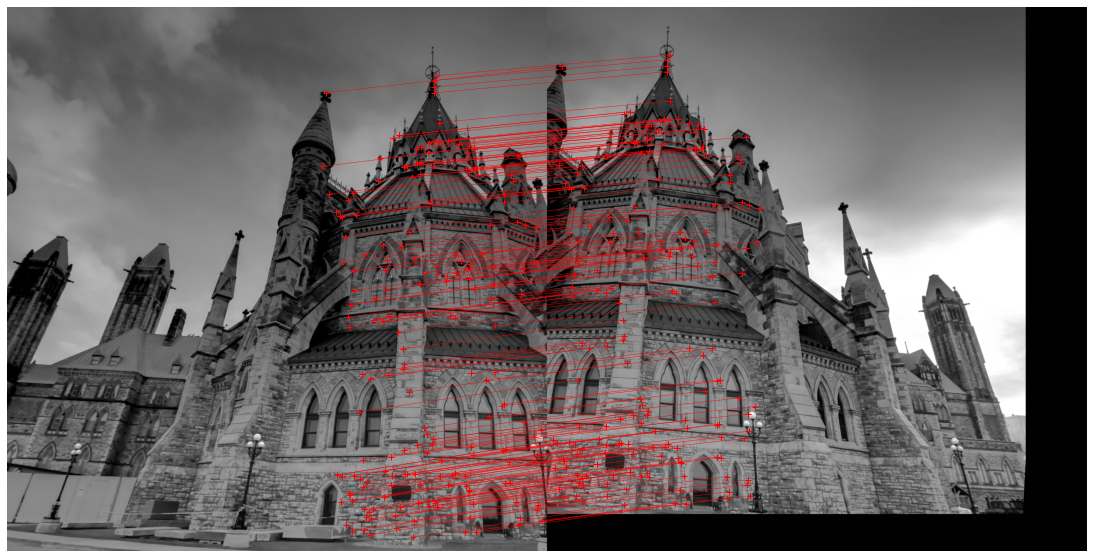

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1_gray, img2_gray, max_inliers)

In [18]:
def warp_images(H, img1, img2):
    h = img1.shape[0]
    w = img1.shape[1] + img2.shape[1]
    c = img1.shape[2]
    trans = ProjectiveTransform(H)
    img2_t = warp(img2, trans, output_shape=(h,w,c)) * 255.
    img2_t = img2_t.astype('int')
    img1_t = np.zeros((h, w, c), dtype = 'int')
    img1_t[:,:img1.shape[1]] = img1
    warped = np.zeros((h, w, c), dtype = 'int')
    for i in range(warped.shape[0]):
        for j in range(warped.shape[1]):
            if (img2_t[i][j] != 0).all():
                warped[i][j] = img2_t[i][j]
            else:
                warped[i][j] = img1_t[i][j]
    return warped

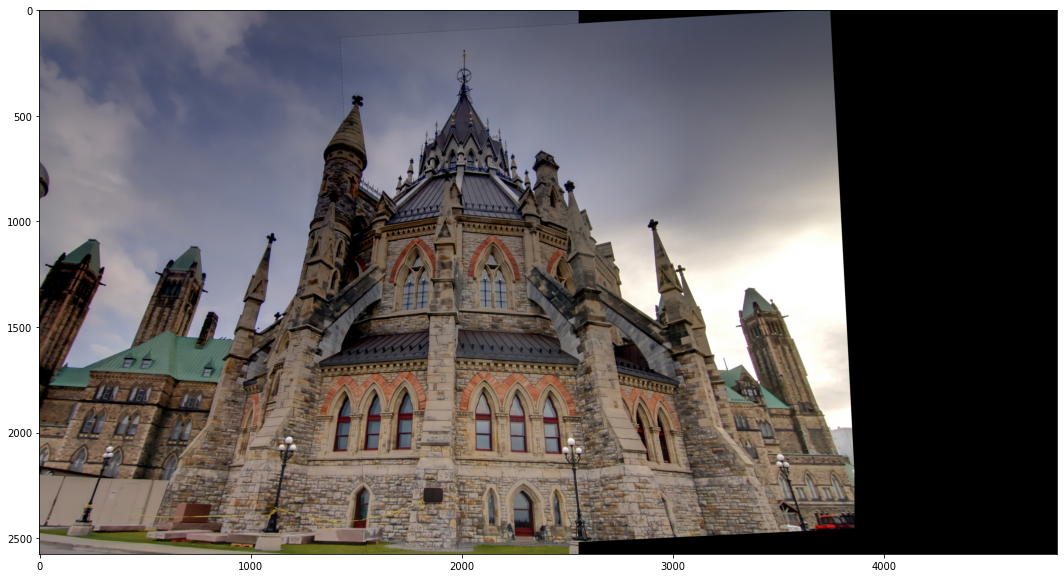

In [20]:
img1 = plt.imread('parliament-left.jpg')
img2 = plt.imread('parliament-right.jpg')
# 7. Create panorama
im = warp_images(Hom, img1, img2)
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(im)

In [111]:
imga = plt.imread('Glendon-Hall-left.jpg')
imgb = plt.imread('Glendon-Hall-middle.jpg')
imgc = plt.imread('Glendon-Hall-right.jpg')
imga_gray = cv.cvtColor(imga,cv.COLOR_RGB2GRAY)
imgb_gray = cv.cvtColor(imgb,cv.COLOR_RGB2GRAY)
imgc_gray = cv.cvtColor(imgc,cv.COLOR_RGB2GRAY)

In [112]:
sift = cv.SIFT_create()
kpa, desa = sift.detectAndCompute(imga_gray,None)
img_a=cv.drawKeypoints(imga_gray,kpa,imga,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# sift = cv.SIFT_create()
kpb, desb = sift.detectAndCompute(imgb_gray,None)
img_b=cv.drawKeypoints(imgb_gray,kpb,imgb,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [ ]:
scores, matches = kornia.feature.match_snn(torch.from_numpy(desa),torch.from_numpy(desb),0.1)
matches_ = [x for _, x in sorted(zip(scores.numpy(), matches.numpy()))]
res = []
m = matches_
scores = sorted(scores.numpy()[:200])
m = m[:200]
kpa, kpb = np.array(kpa), np.array(kpb)
for item in m:
  x1, y1 = kpa[item[0]].pt
  x2, y2 = kpb[item[1]].pt
  res.append([x1, y1, x2, y2])
res = np.array(res, dtype = 'int')
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1_gray, img2_gray, res)

In [ ]:
Hom, max_inliers = ransac(res)
max_inliers = np.array(max_inliers)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, imga_gray, imgb_gray, max_inliers)

In [ ]:
im = warp_images(Hom, imga, imgb)
im_gray = cv.cvtColor(im,cv.COLOR_RGB2GRAY)
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(im_gray)

In [ ]:
kp_, des_ = sift.detectAndCompute(im_gray,None)
im_gray=cv.drawKeypoints(im_gray,kp_,im,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kpc, desc = sift.detectAndCompute(imga_gray,None)
img_c=cv.drawKeypoints(imgc_gray,kpc,imgc,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [ ]:
scores, matches = kornia.feature.match_snn(torch.from_numpy(desc),torch.from_numpy(des_),0.1)
matches_ = [x for _, x in sorted(zip(scores.numpy(), matches.numpy()))]
res = []
m = matches_
scores = sorted(scores.numpy()[:200])
m = m[:200]
kpa, kpb = np.array(kpa), np.array(kpb)
for item in m:
  x1, y1 = kpa[item[0]].pt
  x2, y2 = kpb[item[1]].pt
  res.append([x1, y1, x2, y2])
res = np.array(res, dtype = 'int')
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, im_gray, imgc_gray, res)

In [ ]:
Hom, max_inliers = ransac(res)
max_inliers = np.array(max_inliers)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, imga_gray, imgb_gray, max_inliers)
im_final= warp_images(Hom, im, imgc)
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(im_final)